In [1]:
import os
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model, tree
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    GridSearchCV,
    RandomizedSearchCV,
    #HalvingRandomSearchCV
)
#from sklearn.experimental import enable_halving_search_cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, confusion_matrix, precision_recall_curve, plot_precision_recall_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import xgboost as xgb  # note for installation use py-xgboost in conda

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler 
from imblearn.pipeline import make_pipeline
sns.set_style("whitegrid")

In [3]:
# making code reproducable
np.random.seed(42)

In [4]:
# set path and get raw data
cwd = os.getcwd()
path_data = os.path.join(cwd,"data","pump_sensor.csv")
df = pd.read_csv(path_data,index_col=0)

# Table of Contents
1. The Task
2. The Data
3. Deviation-Indicator
4. ML-Approach

# The task

## Predictive Maintenance
- Using sensor data to predict the breakdowns of pumps.
- Allows for maintenance **before** a pump goes down.

## Benefits
- Cost benefits as regular maintenance-cycles can be reduced.
- No profits are lost due to outages
- Pumps usage period can be extended
- Happy customers stay and are willing to pay a higher premium over competitors.

In [5]:
status_freq = df.machine_status.value_counts()


# The Data

## What data
- Source: Kaggle competition
- 50 sensor data (No 15 is out of service, varying units of measurement)
- Machine status, 
    - normal (205.836), 
    - broken (7) and 
    - recovering (14.477)

## Some Descriptives

- Time period: from 2018, April the first, midnight, to the end of August.
- Frequency of recording: Minutes.
- Number of observations: 220.320



In [6]:
df.loc[:,"timestamp"] = pd.to_datetime(df.timestamp)
df = df.set_index("timestamp")

In [7]:
df.shape

(220320, 53)

In [8]:
df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [9]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [10]:
broken = df.machine_status == "BROKEN"
recovery = df.machine_status == "RECOVERING"
normal = df.machine_status == "NORMAL"


When did the breakdowns happen?

In [11]:
broken_tstamps = df.index[broken]
broken_df = pd.DataFrame(broken_tstamps).rename(columns={"timestamp":"Breakdowns"})

## When Did the Pumps Break?
- Seasonality can not be considered due to sample
- Mostly during nighttime


{{broken_df}}

sensor_15    1.000000
sensor_50    0.349569
sensor_51    0.069821
sensor_00    0.046333
sensor_07    0.024741
sensor_08    0.023180
sensor_06    0.021777
sensor_09    0.020856
sensor_01    0.001675
sensor_30    0.001185
dtype: float64


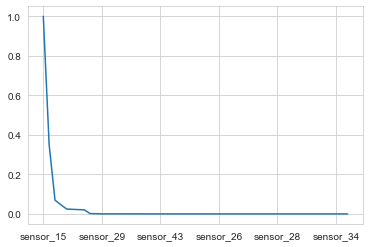

In [13]:
perc_na = df.isna().mean().sort_values(ascending=False)
perc_na.plot()
print(perc_na.iloc[:10])


There are no observations for sensor_15, we drop it.

In [14]:
df = df.drop(["sensor_15"],axis=1)

In [15]:
df.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,215725.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,14.799210,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,2.091963,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,15.053530,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,15.082470,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,15.118630,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,25.000000,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


- There are different units of measurement.


In [16]:
sensor_cols = [col for col in df.columns if col.startswith("sensor")]

In [17]:
scaler = StandardScaler()
df.loc[:,sensor_cols] = scaler.fit_transform(df.loc[:,sensor_cols])

In [18]:
df.loc[:,sensor_cols]

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0.226024,-0.151548,0.639359,1.057629,0.303430,0.177090,-0.041631,0.130935,0.179843,0.121570,...,-0.358948,-0.176788,-0.260504,1.759525,0.185877,-0.588606,0.086292,0.553104,0.919519,-0.011961
2018-04-01 00:01:00,0.226024,-0.151548,0.639359,1.057629,0.303430,0.177090,-0.041631,0.130935,0.179843,0.121570,...,-0.358948,-0.176788,-0.260504,1.759525,0.185877,-0.588606,0.086292,0.553104,0.919519,-0.011961
2018-04-01 00:02:00,0.175906,-0.072552,0.639359,1.093518,0.334771,0.008646,-0.081751,0.088217,0.204698,0.100824,...,-0.358948,-0.200367,-0.285498,1.736986,0.204376,-0.588605,0.061664,0.522874,0.892914,0.009162
2018-04-01 00:03:00,0.214089,-0.151548,0.627523,1.093517,0.260034,0.207684,-0.085093,0.183521,0.243753,0.135404,...,-0.384330,-0.271105,-0.310494,1.691906,0.204376,-0.588606,0.061664,0.507759,0.879613,0.003881
2018-04-01 00:04:00,0.178293,-0.138383,0.639359,1.093517,0.317895,0.184560,-0.068376,0.167089,0.243753,0.135404,...,-0.384330,-0.223946,-0.335489,1.714445,0.241374,-0.533186,0.089811,0.492644,0.906216,-0.011961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 23:55:00,0.085218,0.032772,-0.094513,-0.252232,0.305841,-0.509039,0.747363,0.367557,0.222446,0.173441,...,-0.511246,-0.506895,2.214014,0.722703,0.019383,-0.311513,0.747710,5.042211,NaN,0.259995
2018-08-31 23:56:00,0.068511,0.032772,-0.082675,-0.252232,0.279321,-0.437200,0.764079,0.390563,0.222446,0.152690,...,-0.536628,-0.506895,2.089039,0.587466,0.000884,-0.339222,0.765300,5.178246,NaN,0.259995
2018-08-31 23:57:00,0.058966,0.032772,-0.094513,-0.252232,0.244765,-0.352751,0.733993,0.390563,0.243753,0.152690,...,-0.511246,-0.436158,1.964063,0.452228,0.000884,-0.339222,0.807518,5.132899,NaN,0.267917


In [19]:
def perc_median_shifts(df):
    """ returns percentage median changes over normal median changes when a 
    breakdown takes place
    
    """
    df_broken = df[df.machine_status=="BROKEN"]
    df_normal = df[df.machine_status=="NORMAL"]
    result = (df_broken.median(axis=0)-df_normal.median(axis=0))/df_normal.median(axis=0)
    result = result.abs().sort_values(ascending=False)
    return result

In [20]:
df_perc_shift = perc_median_shifts(df)

## Some Interesting Sensors

### Percentage of Median: Broken vs. Normal

{{df_perc_shift.to_frame().head(5)}}

In [23]:
dict(recovery_start_end)

{Timestamp('2018-04-12 21:56:00'): Timestamp('2018-04-13 13:40:00'),
 Timestamp('2018-04-18 00:31:00'): Timestamp('2018-04-20 04:21:00'),
 Timestamp('2018-05-19 03:19:00'): Timestamp('2018-05-20 01:11:00'),
 Timestamp('2018-05-25 00:31:00'): Timestamp('2018-05-25 10:36:00'),
 Timestamp('2018-06-28 22:01:00'): Timestamp('2018-07-04 17:51:00'),
 Timestamp('2018-07-08 00:12:00'): Timestamp('2018-07-08 00:53:00'),
 Timestamp('2018-07-25 14:01:00'): Timestamp('2018-07-25 15:16:00')}

In [24]:
def add_broken_lines(ymin, ymax):
    for incident in broken_tstamps:
        plt.axvline(incident, ymin,ymax+1, color = "red", alpha=0.5)

In [25]:
def add_recovery_shades(ymin, ymax):
    for i in range(len(recovery_start)):
        plt.axvspan(recovery_start[i], recovery_end[i],ymin=-10,ymax=10, facecolor='red', alpha=.1)

In [26]:
heaviest_first = list(df_perc_shift.index)

In [27]:
i = 4
sensor_name = heaviest_first[i]
sensor = df.loc[:,sensor_name]
def plot_sensor(sensor):
    ax = sensor.plot(ls='-',lw=1)
    ymin = sensor.min()
    ymax = sensor.max()
    #ax.vlines(x=broken_tstabmps, colors='red', ls='-', lw=5, label='vline_multiple',ymin=ymin, ymax=ymax)
    #plt.scatter(x = broken_tstamps, y = df.loc[:,heaviest_first[i]].loc[broken], color="red")
    add_broken_lines(ymin, ymax)  
    add_recovery_shades(ymin, ymax)
#plot_sensor(sensor)


{{plot_sensor(df.filter(regex="_00"))}}


In [29]:
df_corr = df.copy()

df_corr["machine_status"] = df_corr["machine_status"] == "BROKEN"

sensor_coln = df.filter(regex="sensor").columns

df_corr[sensor_coln] = df_corr[sensor_coln].diff(2*24*60)

In [30]:
df_corr

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-04-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-04-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-04-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-04-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 23:55:00,-0.076368,0.105325,-0.236734,-0.556243,-0.053842,-0.537460,0.0,0.000000,0.035501,0.072616,...,0.070737,1.974615,0.946662,0.036998,0.027709,-0.686045,4.927438,NaN,0.287798,False
2018-08-31 23:56:00,-0.081142,0.105325,-0.224894,-0.556245,-0.098042,-0.498625,0.0,0.023006,-0.021307,0.000000,...,0.023579,1.724664,0.788885,0.036999,0.027709,-0.584018,5.139047,NaN,0.308921,False
2018-08-31 23:57:00,-0.102621,0.105325,-0.236734,-0.556243,-0.056254,-0.508905,0.0,0.023006,0.000000,0.031119,...,0.070737,1.499708,0.563489,0.073997,0.055418,-0.467918,5.154160,NaN,0.330044,False


In [31]:
correlation_status_sensor = pd.DataFrame(df_corr.corr().machine_status.sort_values(ascending=False).head())

### Correlation of Sensors with Status
- Order by strength:

{{correlation_status_sensor}}

{{plot_sensor(df.filter(regex="_50"))}}

# Indicator Approach
- When did sensors deviate significantly (5 %-level) from normal state.
- How many sensors deviated 
- Here: Mean of rolling window of 2 days.

In [35]:
df_sensor = df.filter(regex="sensor").copy()

sensor_stdv_normal = df_sensor[normal].std(axis=0)

sensor_means_normal = df_sensor[normal].mean(axis=0)

sensor_abs_diff_from_means = (df_sensor-sensor_means_normal).abs()

n_sensors_2stdv_off = (sensor_abs_diff_from_means/(sensor_stdv_normal*2)>1).sum(axis=1)

rolling_ind = n_sensors_2stdv_off.rolling(24*60*2).mean().dropna()



In [81]:
def rolling_wih_broken_lines():
    # only added for jupyter slides export
    rolling_ind.plot()
    add_broken_lines(-1,3)

{{rolling_wih_broken_lines()}}


## Points to Consider
- Many False Alarms
- There seems to be a time trend (age of pumps)
- An objective rule (still) needs to be developed, when to go looking after pumps.


# ML Approach

## Predicting online
- is it possible to predict breakdowns online?

In [37]:
X = df.drop(labels=["machine_status"], axis=1)
y = broken

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [39]:
y_train.value_counts()

False    165235
True          5
Name: machine_status, dtype: int64

In [40]:
y_test.value_counts()

False    55078
True         2
Name: machine_status, dtype: int64

In [41]:
reg = make_pipeline(SimpleImputer(strategy='median'),
                        StandardScaler(),
                        RandomOverSampler(),
                        LogisticRegression(solver='liblinear')
                        #RandomForestClassifier(n_jobs=-1,max_depth=5)#, max_depth = 3)
                        )

In [42]:
clf_log = reg.fit(X_train, y_train)

In [43]:
y_train_pred = clf_log.predict(X_train)

In [84]:
cm = confusion_matrix(y_train,y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

### Training 
- Simple Logistic Regression, untuned
- split into 75 % Training (5 breakdowns), 25 % Test (2 breakdowns)

{{disp.plot();}}

In [85]:
y_test_pred = reg.predict(X_test)
cm = confusion_matrix(y_test,y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

### Test (Unseen) Data
- one of 2 breakdowns can get predicted

{{disp.plot();}}

In [48]:
param_grid = [
    {
     'logisticregression__penalty' : ['l1', 'l2'],
    'logisticregression__C' : np.logspace(-4, 4, 20)
    },
]

In [49]:
#search = RandomizedSearchCV(reg,param_distributions=param_grid,cv=5,n_jobs=-1)
search = RandomizedSearchCV(reg,param_distributions=param_grid,cv=5)


In [50]:
search.fit( X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomoversampler',
                                              RandomOverSampler()),
                                             ('logisticregression',
                                              LogisticRegression(solver='liblinear'))]),
                   param_distributions=[{'logisticregression__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.000

In [51]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__penalty,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,33.039271,17.647965,0.059981,0.013763,l1,1438.449888,"{'logisticregression__penalty': 'l1', 'logisti...",0.999122,0.999425,0.999122,0.999607,0.999092,0.999274,0.000206,6
1,5.929118,0.769477,0.061202,0.004167,l1,0.000695,"{'logisticregression__penalty': 'l1', 'logisti...",0.987896,0.986020,0.990953,0.987564,0.985415,0.987570,0.001928,9
2,46.932197,25.594007,0.061991,0.013901,l1,206.913808,"{'logisticregression__penalty': 'l1', 'logisti...",0.999122,0.999455,0.999183,0.999697,0.999183,0.999328,0.000218,3
3,11.588191,0.765082,0.059775,0.005876,l2,0.233572,"{'logisticregression__penalty': 'l2', 'logisti...",0.998608,0.998669,0.998638,0.999062,0.998215,0.998638,0.000269,8
4,50.057605,24.247951,0.057788,0.003476,l1,11.288379,"{'logisticregression__penalty': 'l1', 'logisti...",0.999304,0.999395,0.999153,0.999728,0.999062,0.999328,0.000231,3
5,11.022065,0.899013,0.046428,0.002148,l2,1.623777,"{'logisticregression__penalty': 'l2', 'logisti...",0.999122,0.999244,0.999062,0.999486,0.999122,0.999207,0.000151,7
6,11.340703,1.052548,0.050220,0.005629,l2,4.281332,"{'logisticregression__penalty': 'l2', 'logisti...",0.999304,0.999213,0.999062,0.999728,0.999365,0.999334,0.000222,2
7,35.964523,20.251261,0.074794,0.034928,l1,78.475997,"{'logisticregression__penalty': 'l1', 'logisti...",0.999092,0.999425,0.999153,0.999728,0.999122,0.999304,0.000243,5
8,14.944248,2.017061,0.052619,0.008202,l2,11.288379,"{'logisticregression__penalty': 'l2', 'logisti...",0.999334,0.999334,0.999153,0.999637,0.999486,0.999389,0.000163,1
9,3.953371,0.643618,0.048794,0.003190,l1,0.000264,"{'logisticregression__penalty': 'l1', 'logisti...",0.973191,0.974855,0.984749,0.982238,0.967683,0.976543,0.006203,10


In [52]:
best_log = search.best_estimator_

In [88]:
y_test_pred_log = best_log.predict(X_test)
cm = confusion_matrix(y_test,y_test_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

{{disp.plot();}} 

In [54]:
search_f1w = RandomizedSearchCV(reg,param_distributions=param_grid,cv=5, scoring="f1_weighted")

In [55]:
search_f1w.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomoversampler',
                                              RandomOverSampler()),
                                             ('logisticregression',
                                              LogisticRegression(solver='liblinear'))]),
                   param_distributions=[{'logisticregression__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.000

In [56]:
best_log_f1w = search_f1w.best_estimator_

In [ ]:
y_test_pred_log_f1w = best_log.predict(X_test)
cm = confusion_matrix(y_test,y_test_pred_log_f1w)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

{{disp.plot();}}

In [58]:
risk = pd.DataFrame(data=reg.predict_proba(df_sensor),index=df.index)

In [59]:
days_warning = 2
lag = days_warning*24*60
X_test_lag = X_test.shift(lag).iloc[lag:,:]
X_train_lag = X_train.shift(lag).iloc[lag:,:]
y_test_lag = y_test.astype('int').shift(lag).dropna()
y_train_lag = y_train.astype('int').shift(lag).dropna()

In [60]:
clf_log_lag = reg.fit(X_train_lag, y_train_lag)

In [61]:
risk_lag = pd.DataFrame(data=clf_log_lag.predict_proba(df_sensor),index=df.index)

## Early Warning Indicator
- Give maintenance staff an early indicator of 2d.
- Point forecasts of breakdowns failed so far.
- Probabilities of breakdown, however, serve as early warning indicator.

{{plot_sensor(risk_lag.shift(-lag).loc[:,1]);}}

In [63]:
search_f1w_lag = RandomizedSearchCV(reg,param_distributions=param_grid,cv=5, scoring="f1_weighted")

In [64]:
search_f1w_lag.fit(X_train_lag, y_train_lag)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomoversampler',
                                              RandomOverSampler()),
                                             ('logisticregression',
                                              LogisticRegression(solver='liblinear'))]),
                   param_distributions=[{'logisticregression__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.000

# Next Steps
- Use different ML-Models, including LSTM.
- Fine-tune models
- Use early-warning indicator and/or deviation-indicator in models.
- Use PCA to shrink number of regressors

**THANK YOU!**